*Latex Commands*
$$\newcommand{\bp}{\begin{pmatrix}}
\newcommand{\ep}{\end{pmatrix}}$$

In [1]:
from abc import ABCMeta
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares, fsolve
from tqdm import tqdm
import sys
sys.path.append('../')
from lib.findiff import *

In [2]:
class FiniteDifferenceFunctions(metaclass=ABCMeta):
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = dx
        self.dy = dy
    def grad(self,v):
        v = v.reshape(self.m,self.n)
        return np.array(np.gradient(v,self.dx,self.dy,axis=(1,0),edge_order=1))#[::-1]
    def div(self,v):
        v = v.reshape(2,self.m,self.n)
        return np.array(np.gradient(v[0],self.dx,axis=(1),edge_order=1))+np.array(np.gradient(v[1],self.dy,axis=(0),edge_order=1))
    def divGrad(self,v):
        v = v.reshape(self.m,self.n)
        return self.div(self.grad(v))
    def Agrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return mult(self.A,self.grad(v))
    def divAgrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return self.div(mult(self.A,self.grad(v)))

In [3]:
class FiniteDifferenceMatrices(metaclass=ABCMeta):
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = dx
        self.dy = dy
    def grad(self):
        n,m = self.n,self.m
        #X-MAT
        x_diag = np.diag(([-1]+[0]*(m-2)+[1])*(n),0)
        x_supdiag = np.diag(([1]+[.5]*(m-2)+[0])*(n-1)+([1]+[.5]*(m-2)),1)
        x_subdiag = np.diag(([-.5]*(m-2)+[-1]+[0])*(n-1)+([-.5]*(m-2)+[-1]),-1)
        x_mtrx = x_subdiag + x_diag + x_supdiag
        #Y-MAT
        y_diag = np.diag([-1]*m+[0]*m*(n-2)+[1]*m,0)
        y_supdiag = np.diag([1]*m+[.5]*m*(n-2),m)
        y_subdiag = np.diag([-.5]*m*(n-2)+[-1]*m,-m)
        y_mtrx = y_subdiag + y_diag + y_supdiag
        return np.array([x_mtrx/self.dx,y_mtrx/self.dy])
    def div(self):
        return np.moveaxis(self.grad(),0,-1)
    def divGrad(self):
        return np.tensordot(self.div(),self.grad(),axes=([2,1],[0,1]))
    def Agrad(self):
        assert (self.A is not None)
        A = self.A.reshape([2,2,self.m*self.n])
        mult = lambda A,v: np.einsum('ijk,jkl->ikl',A,v)
        return mult(A,self.grad())
    def divAgrad(self):
        assert (self.A is not None)
        A = self.A.reshape([2,2,self.m*self.n])
        mult = lambda A,v: np.einsum('ijk,jkl->ikl',A,v)
        return np.tensordot(self.div(),mult(A,self.grad()),axes=([2,1],[0,1]))

In [4]:
#GRID
n,m=21,21
y=np.linspace(-1,1,n)
x=np.linspace(-1,1,m)
dx = 2/(n+1)
dy = 2/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)
fdf = FiniteDifferenceFunctions(m,n,dx,dy)
fdm = FiniteDifferenceMatrices(m,n,dx,dy)
f = xx**3+yy**2

### Gradients

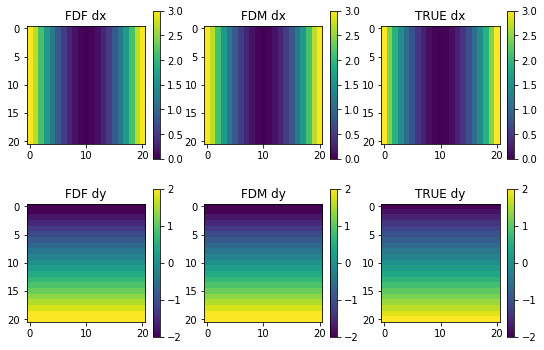

In [5]:
plt.figure(figsize=(9,6))
plt.subplot(231)
plt.imshow(fdf.grad(f)[0],vmin=0,vmax=3)
plt.title('FDF dx')
plt.colorbar()
plt.subplot(232)
plt.imshow((fdm.grad()[0]@f.flatten()).reshape(n,m),vmin=0,vmax=3)
plt.colorbar()
plt.title('FDM dx')
plt.subplot(233)
plt.imshow(3*xx**2,vmin=0,vmax=3)
plt.colorbar()
plt.title('TRUE dx')
plt.subplot(234)
plt.imshow(fdf.grad(f)[1],vmin=-2,vmax=2)
plt.title('FDF dy')
plt.colorbar()
plt.subplot(235)
plt.imshow((fdm.grad()[1]@f.flatten()).reshape(n,m),vmin=-2,vmax=2)
plt.colorbar()
plt.title('FDM dy')
plt.subplot(236)
plt.imshow(2*yy,vmin=-2,vmax=2)
plt.colorbar()
plt.title('TRUE dy')
plt.show()

### Divergence

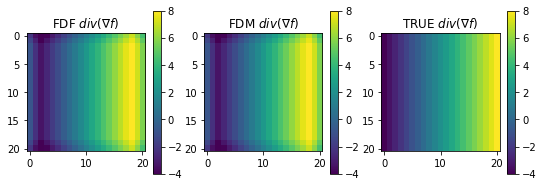

In [6]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(fdf.divGrad(f),vmin=-4,vmax=8)
plt.title('FDF $div(\\nabla f)$')
plt.colorbar()
plt.subplot(132)
plt.imshow((fdm.divGrad()@f.flatten()).reshape(n,m),vmin=-4,vmax=8)
plt.colorbar()
plt.title('FDM $div(\\nabla f)$')
plt.subplot(133)
plt.imshow(6*xx+2*np.ones(domain_shape),vmin=-4,vmax=8)
plt.colorbar()
plt.title('TRUE $div(\\nabla f)$')
plt.show()

### A Gradients

In [7]:
A = .5*np.eye(2)
A  = np.array([[A]*n]*m).T
fdf.A = A
fdm.A = A

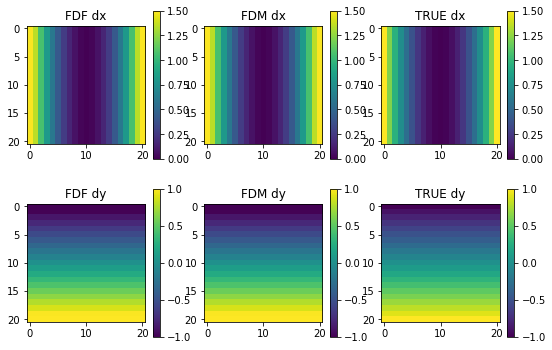

In [8]:
plt.figure(figsize=(9,6))
plt.subplot(231)
plt.imshow(fdf.Agrad(f)[0],vmin=0,vmax=1.5)
plt.title('FDF dx')
plt.colorbar()
plt.subplot(232)
plt.imshow((fdm.Agrad()[0]@f.flatten()).reshape(n,m),vmin=0,vmax=1.5)
plt.colorbar()
plt.title('FDM dx')
plt.subplot(233)
plt.imshow(1.5*xx**2,vmin=0,vmax=1.5)
plt.colorbar()
plt.title('TRUE dx')
plt.subplot(234)
plt.imshow(fdf.Agrad(f)[1],vmin=-1,vmax=1)
plt.title('FDF dy')
plt.colorbar()
plt.subplot(235)
plt.imshow((fdm.Agrad()[1]@f.flatten()).reshape(n,m),vmin=-1,vmax=1)
plt.colorbar()
plt.title('FDM dy')
plt.subplot(236)
plt.imshow(yy,vmin=-1,vmax=1)
plt.colorbar()
plt.title('TRUE dy')
plt.show()

### A Divergences

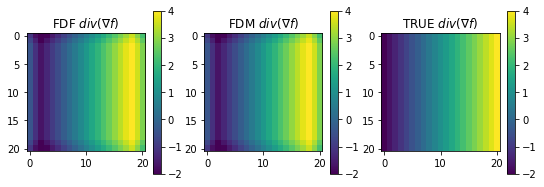

In [9]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(fdf.divAgrad(f),vmin=-2,vmax=4)
plt.title('FDF $div(\\nabla f)$')
plt.colorbar()
plt.subplot(132)
plt.imshow((fdm.divAgrad()@f.flatten()).reshape(n,m),vmin=-2,vmax=4)
plt.colorbar()
plt.title('FDM $div(\\nabla f)$')
plt.subplot(133)
plt.imshow(3*xx+np.ones(domain_shape),vmin=-2,vmax=4)
plt.colorbar()
plt.title('TRUE $div(\\nabla f)$')
plt.show()

### Slightly More Complex A

In [10]:
A = np.array([[np.sqrt(2)/2,np.sqrt(2)/2],[-np.sqrt(2)/2,np.sqrt(2)/2]])
A  = np.array([[A]*n]*m).T
print("Eigen Values: {}\nEigen Vectors:\n {}".format(np.linalg.eig(A[:,:,0,0])[0],np.linalg.eig(A[:,:,0,0])[1]))
fdf.A = A
fdm.A = A

Eigen Values: [0.70710678+0.70710678j 0.70710678-0.70710678j]
Eigen Vectors:
 [[ 0.        -0.70710678j  0.        +0.70710678j]
 [-0.70710678+0.j         -0.70710678-0.j        ]]


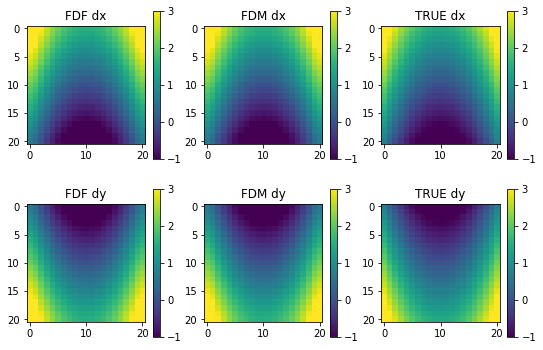

In [11]:
plt.figure(figsize=(9,6))
plt.subplot(231)
plt.imshow(fdf.Agrad(f)[0],vmin=-1,vmax=3)
plt.title('FDF dx')
plt.colorbar()
plt.subplot(232)
plt.imshow((fdm.Agrad()[0]@f.flatten()).reshape(n,m),vmin=-1,vmax=3)
plt.colorbar()
plt.title('FDM dx')
plt.subplot(233)
plt.imshow(1/np.sqrt(2)*(3*xx**2)-1/np.sqrt(2)*(2*yy),vmin=-1,vmax=3)
plt.colorbar()
plt.title('TRUE dx')
plt.subplot(234)
plt.imshow(fdf.Agrad(f)[1],vmin=-1,vmax=3)
plt.title('FDF dy')
plt.colorbar()
plt.subplot(235)
plt.imshow((fdm.Agrad()[1]@f.flatten()).reshape(n,m),vmin=-1,vmax=3)
plt.colorbar()
plt.title('FDM dy')
plt.subplot(236)
plt.imshow(1/np.sqrt(2)*(3*xx**2)+1/np.sqrt(2)*(2*yy),vmin=-1,vmax=3)
plt.colorbar()
plt.title('TRUE dy')
plt.show()

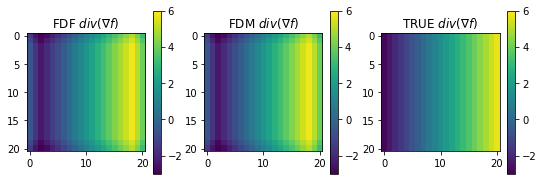

In [12]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(fdf.divAgrad(f),vmin=-3,vmax=6)
plt.title('FDF $div(\\nabla f)$')
plt.colorbar()
plt.subplot(132)
plt.imshow((fdm.divAgrad()@f.flatten()).reshape(n,m),vmin=-3,vmax=6)
plt.colorbar()
plt.title('FDM $div(\\nabla f)$')
plt.subplot(133)
plt.imshow(3*np.sqrt(2)*xx+np.sqrt(2)*np.ones(domain_shape),vmin=-3,vmax=6)
plt.colorbar()
plt.title('TRUE $div(\\nabla f)$')
plt.show()

### Non-Symmetric A

In [13]:
A = np.array([[1/2,-np.sqrt(3)/2],[np.sqrt(3)/2,1/2]])
A  = np.array([[A]*n]*m).T
print("Eigen Values: {}\nEigen Vectors:\n {}".format(np.linalg.eig(A[:,:,0,0])[0],np.linalg.eig(A[:,:,0,0])[1]))
fdf.A = A
fdm.A = A

Eigen Values: [0.5+0.8660254j 0.5-0.8660254j]
Eigen Vectors:
 [[0.70710678+0.j         0.70710678-0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]


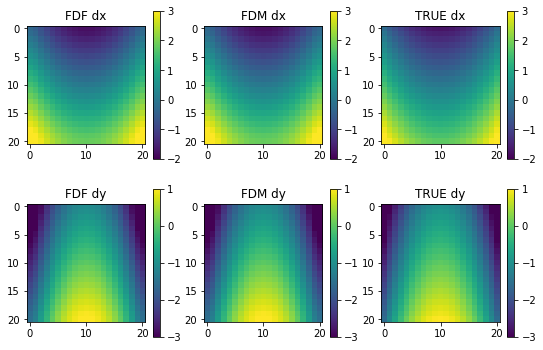

In [14]:
plt.figure(figsize=(9,6))
plt.subplot(231)
plt.imshow(fdf.Agrad(f)[0],vmin=-2,vmax=3)
plt.title('FDF dx')
plt.colorbar()
plt.subplot(232)
plt.imshow((fdm.Agrad()[0]@f.flatten()).reshape(n,m),vmin=-2,vmax=3)
plt.colorbar()
plt.title('FDM dx')
plt.subplot(233)
plt.imshow(.5*(3*xx**2)+np.sqrt(3)*yy,vmin=-2,vmax=3)
plt.colorbar()
plt.title('TRUE dx')
plt.subplot(234)
plt.imshow(fdf.Agrad(f)[1],vmin=-3,vmax=1)
plt.title('FDF dy')
plt.colorbar()
plt.subplot(235)
plt.imshow((fdm.Agrad()[1]@f.flatten()).reshape(n,m),vmin=-3,vmax=1)
plt.colorbar()
plt.title('FDM dy')
plt.subplot(236)
plt.imshow(-np.sqrt(3)/2*(3*xx**2)+yy,vmin=-3,vmax=1)
plt.colorbar()
plt.title('TRUE dy')
plt.show()

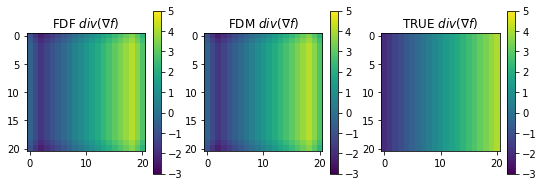

In [15]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(fdf.divAgrad(f),vmin=-3,vmax=5)
plt.title('FDF $div(\\nabla f)$')
plt.colorbar()
plt.subplot(132)
plt.imshow((fdm.divAgrad()@f.flatten()).reshape(n,m),vmin=-3,vmax=5)
plt.colorbar()
plt.title('FDM $div(\\nabla f)$')
plt.subplot(133)
plt.imshow(3*xx+np.ones(domain_shape),vmin=-3,vmax=5)
plt.colorbar()
plt.title('TRUE $div(\\nabla f)$')
plt.show()

## PDE Solvers

In [16]:
#GRID
n,m=21,21
y=np.linspace(-1,1,n)
x=np.linspace(-1,1,m)
dx = x[1]-x[0]
dy = y[1]-y[0]
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)
f = xx**3+yy**2
fdf = FiniteDifferenceFunctions(m,n,dx,dy)
fdm = FiniteDifferenceMatrices(m,n,dx,dy)

### Boundaries

#### Interior

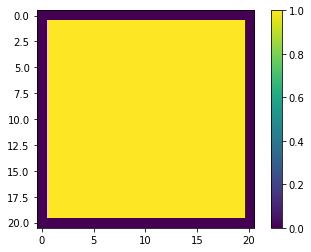

In [17]:
interior = np.ones(domain_shape)
interior[0,:]=np.zeros(n); interior[-1,:]=np.zeros(n)
interior[:,0]=np.zeros(m); interior[:,-1]=np.zeros(m)
plt.imshow(interior)
plt.colorbar()


In [18]:
interior = np.diag(interior.reshape(domain_len))

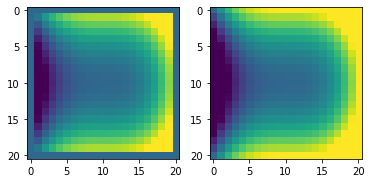

In [19]:
plt.subplot(121)
plt.imshow((interior@f.reshape(domain_len)).reshape(domain_shape),vmin=-.5,vmax=1)
plt.subplot(122)
plt.imshow(f,vmin=-.5,vmax=1)

In [20]:
A = np.array([[np.sqrt(2)/2,np.sqrt(2)/2],[-np.sqrt(2)/2,np.sqrt(2)/2]])
A  = np.array([[A]*n]*m).T
print("Eigen Values: {}\nEigen Vectors:\n {}".format(np.linalg.eig(A[:,:,0,0])[0],np.linalg.eig(A[:,:,0,0])[1]))
fdf.A = A
fdm.A = A

Eigen Values: [0.70710678+0.70710678j 0.70710678-0.70710678j]
Eigen Vectors:
 [[ 0.        -0.70710678j  0.        +0.70710678j]
 [-0.70710678+0.j         -0.70710678-0.j        ]]


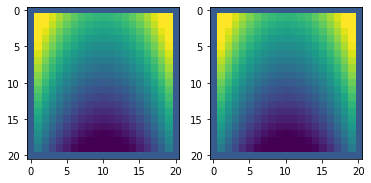

In [21]:
plt.subplot(121)
plt.imshow((interior@(fdm.Agrad()[0]@f.reshape(domain_len))).reshape(domain_shape),vmin=-1,vmax=2.5)
plt.subplot(122)
plt.imshow((interior@(1/np.sqrt(2)*(3*xx**2)-1/np.sqrt(2)*(2*yy)).flatten()).reshape(domain_shape),vmin=-1,vmax=2.5)
plt.show()

#### Dirichlet

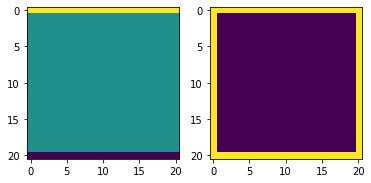

In [22]:
dirichlet_bc = np.zeros(domain_shape)
dirichlet_bc[0,:] = np.ones(m)
dirichlet_bc[-1,:] = -np.ones(m)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc = np.ones(domain_shape) - np.diag(interior).reshape(n,m)
plt.subplot(121)
plt.imshow(dirichlet_bc)
plt.subplot(122)
plt.imshow(dirichlet_loc)

In [23]:
dirichlet_loc = np.diag(dirichlet_loc.reshape(domain_len))
dirichlet_bc = dirichlet_bc.reshape(domain_len)

In [24]:
primal = (interior@fdm.divGrad()+dirichlet_loc)
u = np.linalg.solve(primal,dirichlet_bc)

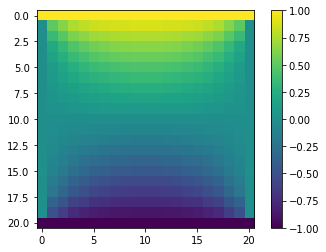

In [25]:
plt.imshow(u.reshape(domain_shape))
plt.colorbar()
plt.show()

#### Neumann

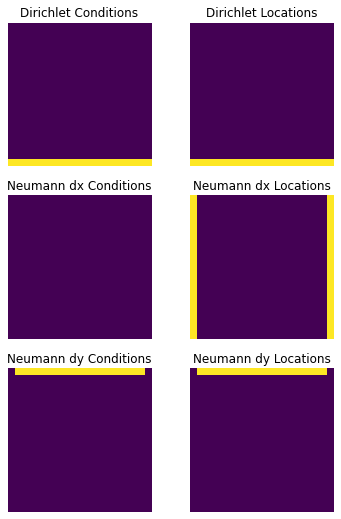

In [34]:
neumann_xbc = np.zeros(domain_shape)
neumann_ybc = np.zeros(domain_shape)
neumann_ybc[0,1:-1] = np.ones(n-2)
neumann_xloc = np.zeros(domain_shape)
neumann_xloc[:,0]=np.ones(n)
neumann_xloc[:,-1]=np.ones(n)
neumann_yloc = np.zeros(domain_shape)
neumann_yloc[0,1:-1] = np.ones(n-2)
dirichlet_bc = np.zeros(domain_shape)
dirichlet_bc[-1,:]=np.ones(n)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[-1,:]=np.ones(n)
plt.figure(figsize=(6,9))
plt.subplot(321)
plt.imshow(dirichlet_bc)
plt.title('Dirichlet Conditions')
plt.axis('off')
plt.subplot(322)
plt.imshow(dirichlet_loc)
plt.title('Dirichlet Locations')
plt.axis('off')
plt.subplot(323)
plt.imshow(neumann_xbc)
plt.title('Neumann dx Conditions')
plt.axis('off')
plt.subplot(324)
plt.imshow(neumann_xloc)
plt.title('Neumann dx Locations')
plt.axis('off')
plt.subplot(325)
plt.imshow(neumann_ybc)
plt.title('Neumann dy Conditions')
plt.axis('off')
plt.subplot(326)
plt.imshow(neumann_yloc)
plt.title('Neumann dy Locations')
plt.axis('off')
plt.show()

In [27]:
dirichlet_loc = np.diag(dirichlet_loc.reshape(domain_len))
dirichlet_bc = dirichlet_bc.reshape(domain_len)
neumann_xbc = neumann_xbc.reshape(domain_len)
neumann_ybc = neumann_ybc.reshape(domain_len)
neumann_xloc = np.diag(neumann_xloc.reshape(domain_len))
neumann_yloc = np.diag(neumann_yloc.reshape(domain_len))

In [28]:
primal = (interior@fdm.divGrad()+neumann_xloc@(fdm.grad()[0])+neumann_yloc@(fdm.grad()[1])+dirichlet_loc)
u = np.linalg.solve(primal,neumann_xbc+neumann_ybc+dirichlet_bc)

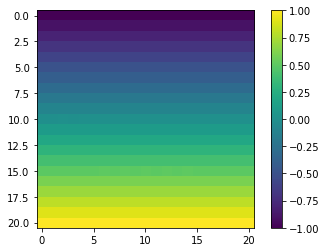

In [31]:
plt.imshow(u.reshape(domain_shape))
plt.colorbar()

### PDE Class

In [77]:
class PDESolver(metaclass=ABCMeta):
    def __init__(self,m,n,fdm,interior,dirichlet_bc,dirichlet_loc,neumann_xbc,neumann_xloc,neumann_ybc,neumann_yloc):
        self.domain_shape = (m,n)
        self.domain_len = m*n
        self.fdm = fdm
        assert np.array_equal(interior+dirichlet_loc+neumann_xloc+neumann_yloc,np.ones(neumann_yloc.shape)), "Not equivalent to ones: {}".format(np.where(interior+dirichlet_loc+neumann_xloc+neumann_yloc-np.ones(neumann_yloc.shape)!=0))
        self.interior = np.diag(interior.reshape(self.domain_len))
        self.dirichlet_bc = dirichlet_bc.reshape(self.domain_len)
        self.dirichlet_loc = np.diag(dirichlet_loc.reshape(self.domain_len))
        self.neumann_xbc = neumann_xbc.reshape(self.domain_len)
        self.neumann_xloc = np.diag(neumann_xloc.reshape(self.domain_len))
        self.neumann_ybc = neumann_ybc.reshape(self.domain_len)
        self.neumann_yloc = np.diag(neumann_yloc.reshape(self.domain_len))
    def divAgrad(self):
        pde_mtrx = (self.interior@-self.fdm.divAgrad()+self.neumann_xloc@(self.fdm.Agrad()[0])+self.neumann_yloc@(self.fdm.Agrad()[1])+self.dirichlet_loc)
        return np.linalg.solve(pde_mtrx,self.neumann_xbc+self.neumann_ybc+self.dirichlet_bc)

In [78]:
#GRID
n,m=21,21
y=np.linspace(-1,1,n)
x=np.linspace(-1,1,m)
dx = x[1]-x[0]
dy = y[1]-y[0]
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)
f = xx**3+yy**2
fdf = FiniteDifferenceFunctions(m,n,dx,dy)
fdm = FiniteDifferenceMatrices(m,n,dx,dy)

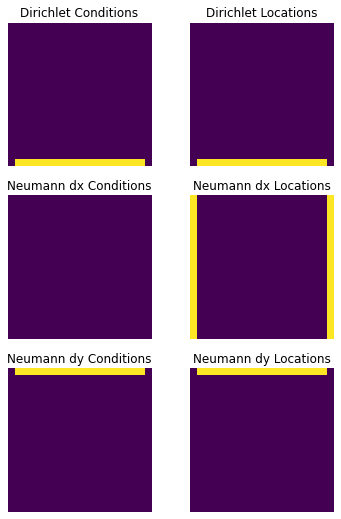

In [79]:
interior = np.ones(domain_shape)
interior[0,:] = np.zeros(n)
interior[-1,:] = np.zeros(n)
interior[:,0] = np.zeros(n)
interior[:,-1] = np.zeros(n)
neumann_xbc = np.zeros(domain_shape)
neumann_ybc = np.zeros(domain_shape)
neumann_ybc[0,1:-1] = np.ones(n-2)
neumann_xloc = np.zeros(domain_shape)
neumann_xloc[:,0]=np.ones(n)
neumann_xloc[:,-1]=np.ones(n)
neumann_yloc = np.zeros(domain_shape)
neumann_yloc[0,1:-1] = np.ones(n-2)
dirichlet_bc = np.zeros(domain_shape)
dirichlet_bc[-1,1:-1]=np.ones(n-2)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[-1,1:-1]=np.ones(n-2)
plt.figure(figsize=(6,9))
plt.subplot(321)
plt.imshow(dirichlet_bc)
plt.title('Dirichlet Conditions')
plt.axis('off')
plt.subplot(322)
plt.imshow(dirichlet_loc)
plt.title('Dirichlet Locations')
plt.axis('off')
plt.subplot(323)
plt.imshow(neumann_xbc)
plt.title('Neumann dx Conditions')
plt.axis('off')
plt.subplot(324)
plt.imshow(neumann_xloc)
plt.title('Neumann dx Locations')
plt.axis('off')
plt.subplot(325)
plt.imshow(neumann_ybc)
plt.title('Neumann dy Conditions')
plt.axis('off')
plt.subplot(326)
plt.imshow(neumann_yloc)
plt.title('Neumann dy Locations')
plt.axis('off')
plt.show()

In [80]:
pde = PDESolver(m,n,fdm,interior,dirichlet_bc,dirichlet_loc,neumann_xbc,neumann_xloc,neumann_ybc,neumann_yloc)

Eigen Values: [0.70710678+0.70710678j 0.70710678-0.70710678j]
Eigen Vectors:
 [[ 0.        -0.70710678j  0.        +0.70710678j]
 [-0.70710678+0.j         -0.70710678-0.j        ]]


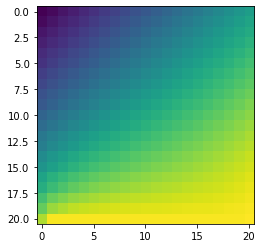

In [81]:
A = np.array([[np.sqrt(2)/2,np.sqrt(2)/2],[-np.sqrt(2)/2,np.sqrt(2)/2]])
A  = np.array([[A]*n]*m).T
print("Eigen Values: {}\nEigen Vectors:\n {}".format(np.linalg.eig(A[:,:,0,0])[0],np.linalg.eig(A[:,:,0,0])[1]))
fdm.A = A
pde.fdm = fdm
u = pde.divAgrad()
plt.imshow(u.reshape(domain_shape))

Eigen Values: [0.5+0.8660254j 0.5-0.8660254j]
Eigen Vectors:
 [[0.70710678+0.j         0.70710678-0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]


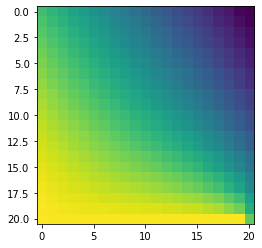

In [82]:
A = np.array([[1/2,-np.sqrt(3)/2],[np.sqrt(3)/2,1/2]])
A  = np.array([[A]*n]*m).T
print("Eigen Values: {}\nEigen Vectors:\n {}".format(np.linalg.eig(A[:,:,0,0])[0],np.linalg.eig(A[:,:,0,0])[1]))
fdm.A = A
pde.fdm = fdm
u = pde.divAgrad()
plt.imshow(u.reshape(domain_shape))